<a href="https://colab.research.google.com/github/BenyaminZojaji/Deep_Learning/blob/main/Age%20Estimation/ageEstimation-23k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!ls -a ~/.kaggle

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new
!unzip utkface-new.zip

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [4]:
width = height = 224
batch_size = 32

In [ ]:
images = [] # X
ages = [] # Y

for image_name in os.listdir('/content/utkface_aligned_cropped/crop_part1'):
  ages.append(int(image_name.split('_')[0]))

  image = cv2.imread(f'/content/utkface_aligned_cropped/crop_part1/{image_name}')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (width, height))
  images.append(image)

In [ ]:
images = pd.Series(images, name='Images')
ages = pd.Series(ages, name='Ages')

dataframe = pd.concat([images, ages], axis=1)
dataframe.head()

,Images,Ages
0,"[[[150, 127, 113], [155, 132, 118], [163, 140,...",62
1,"[[[32, 33, 35], [32, 33, 35], [33, 34, 36], [3...",48
2,"[[[252, 254, 253], [251, 253, 252], [251, 252,...",1
3,"[[[37, 34, 29], [38, 35, 30], [40, 36, 30], [4...",18
4,"[[[219, 217, 228], [219, 217, 228], [218, 215,...",39


In [ ]:
dataframe.shape

(9780, 2)

62


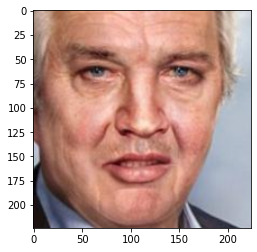

In [ ]:
print(dataframe['Ages'][0])
plt.imshow(dataframe['Images'][0])
plt.show()

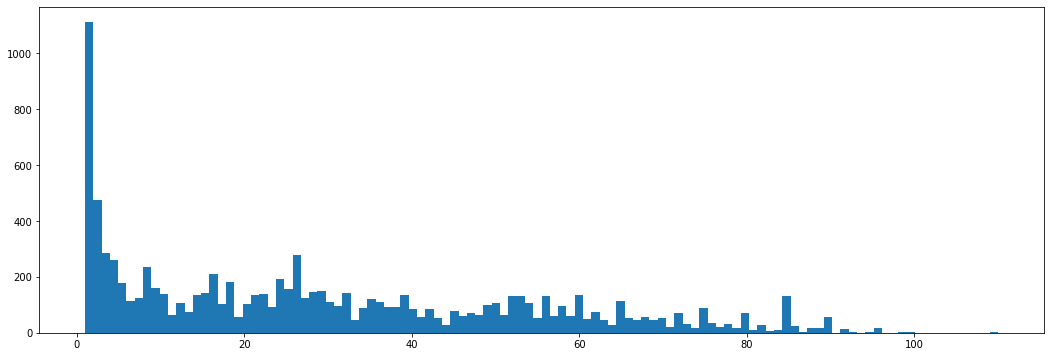

In [ ]:
plt.figure(figsize=(18, 6))
plt.hist(dataframe['Ages'], bins=dataframe['Ages'].max())
plt.show()

In [ ]:
under_4 = dataframe[dataframe['Ages'] <= 4]
under_4_new = under_4.sample(frac=0.3)

up_4 = dataframe[dataframe['Ages'] > 4]

dataframe = pd.concat([under_4_new, up_4], axis=0)

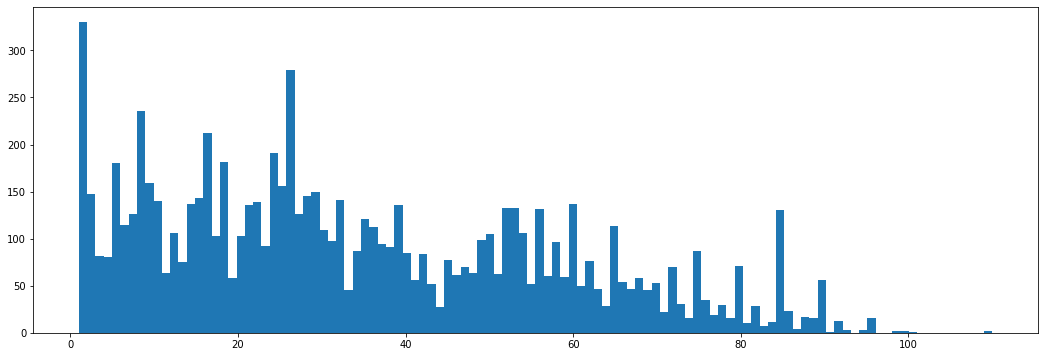

In [ ]:
plt.figure(figsize=(18, 6))
plt.hist(dataframe['Ages'], bins=dataframe['Ages'].max())
plt.show()

In [ ]:
X = np.array(dataframe['Images'].values.tolist())
Y = np.array(dataframe['Ages'].values.tolist())

In [ ]:
print(X.shape)
print(Y.shape)

(8288, 224, 224, 3)
(8288,)


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(6630, 224, 224, 3)
(1658, 224, 224, 3)
(6630,)
(1658,)


In [ ]:
idg = ImageDataGenerator(rescale=1./255,
                         horizontal_flip=True,
                         )
train_data = idg.flow(X_train, Y_train, batch_size=batch_size)
val_data = idg.flow(X_val, Y_val, batch_size=batch_size)

### Train

In [ ]:
base_model = tf.keras.applications.Xception(
    input_shape = (width, height, 3),
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

In [ ]:
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
                             base_model,
                             Dropout(0.5),
                             Dense(1)
])

In [ ]:
model.compile(optimizer=Adam(),
              loss=tf.keras.losses.mse)

In [ ]:
model.fit(train_data, validation_data=val_data, epochs=20, shuffle=True)

Epoch 1/20
208/208 [==============================] - 87s 402ms/step - loss: 445.1893 - val_loss: 157.0190
Epoch 2/20
208/208 [==============================] - 83s 398ms/step - loss: 160.2462 - val_loss: 142.1984
Epoch 3/20
208/208 [==============================] - 83s 399ms/step - loss: 140.8151 - val_loss: 149.6323
Epoch 4/20
208/208 [==============================] - 83s 399ms/step - loss: 129.1274 - val_loss: 146.7122
Epoch 5/20
208/208 [==============================] - 83s 400ms/step - loss: 119.5699 - val_loss: 127.4383
Epoch 6/20
208/208 [==============================] - 84s 405ms/step - loss: 116.5004 - val_loss: 121.4342
Epoch 7/20
208/208 [==============================] - 83s 398ms/step - loss: 103.0864 - val_loss: 180.8490
Epoch 8/20
208/208 [==============================] - 83s 398ms/step - loss: 101.1716 - val_loss: 143.2186
Epoch 9/20
208/208 [==============================] - 83s 399ms/step - loss: 96.0519 - val_loss: 120.2317
Epoch 10/20
208/208 [=================

In [ ]:
model.save('xception-ageEstimation.h5')

### Inference

In [ ]:
image = cv2.imread('/content/16.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (width, height))
image = image/255
image = image[np.newaxis, ...]

result = model.predict(image)
print(result)

[[34.84138]]


### 23K Image

In [5]:
images = [] # X
ages = [] # Y
DIR = '/content/UTKFace/'

for image_name in os.listdir(DIR):
    age = int(image_name.split('_')[0])
    if age<=4 and (random.choices([True, False], cum_weights=(70, 30))[0]):
        continue
    if random.choices([True, False], cum_weights=(35, 65))[0]:
        continue
    ages.append(age)
    image = cv2.imread(f'{DIR}{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    images.append(image)

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(np.array(pd.Series(images, name='Images').values.tolist()), np.array(pd.Series(ages, name='Ages').values.tolist()), test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(7908, 224, 224, 3)
(1977, 224, 224, 3)
(7908,)
(1977,)


In [7]:
idg = ImageDataGenerator(rescale=1./255,
                         horizontal_flip=True,
                         )
train_data = idg.flow(X_train, Y_train, batch_size=batch_size)
val_data = idg.flow(X_val, Y_val, batch_size=batch_size)

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape = (width, height, 3),
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

In [9]:
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [10]:
model = tf.keras.Sequential([
                             base_model,
                             Dropout(0.5),
                             Dense(1)
])

In [11]:
model.compile(optimizer=Adam(),
              loss=tf.keras.losses.mse)

In [12]:
model.fit(train_data, validation_data=val_data, epochs=10, shuffle=True)

Epoch 1/10
248/248 [==============================] - 78s 254ms/step - loss: 578.6626 - val_loss: 362.6829
Epoch 2/10
248/248 [==============================] - 60s 243ms/step - loss: 301.2593 - val_loss: 248.6703
Epoch 3/10
248/248 [==============================] - 60s 243ms/step - loss: 231.9728 - val_loss: 197.4274
Epoch 4/10
248/248 [==============================] - 60s 243ms/step - loss: 200.5521 - val_loss: 179.1208
Epoch 5/10
248/248 [==============================] - 60s 243ms/step - loss: 186.4771 - val_loss: 165.9349
Epoch 6/10
248/248 [==============================] - 60s 243ms/step - loss: 178.0321 - val_loss: 160.8235
Epoch 7/10
248/248 [==============================] - 60s 243ms/step - loss: 172.8459 - val_loss: 153.6696
Epoch 8/10
248/248 [==============================] - 60s 243ms/step - loss: 169.0927 - val_loss: 156.3598
Epoch 9/10
248/248 [==============================] - 60s 243ms/step - loss: 168.0521 - val_loss: 145.8954
Epoch 10/10
248/248 [================

In [ ]:
model.save('Resnet50V2-ageEstimation.h5')